In [112]:
from scipy.stats import iqr,skew,kurtosis,variation
from datetime import datetime
from copy import deepcopy
import math
from scipy.stats import pearsonr
from sklearn.externals.joblib import Parallel,delayed
import warnings
import pandas as pd
import pickle
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest,f_classif
from sklearn.decomposition import PCA
from pprint import pprint
from sklearn.metrics import f1_score,r2_score,classification_report,roc_auc_score
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,RandomForestRegressor
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix,f1_score,precision_score,recall_score,accuracy_score
import itertools
from sklearn.model_selection import ParameterGrid, cross_val_predict, GroupKFold,GridSearchCV,StratifiedKFold
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn import metrics
import warnings
from sklearn.metrics import roc_curve, auc, roc_auc_score, make_scorer
warnings.filterwarnings('ignore')

def get_daywise(data,ema):
    df_col = []
    for day in np.unique(ema['day'].values):
        df = data[data.day.isin([day])]
        if df.shape[0]<60:
            continue
        df_day = ema[ema.day.isin([day])]
        if df_day.shape[0]<1:
            continue
        df_col.append([df,df_day])
    return df_col

from pandas.core.window import _flex_binary_moment, _Rolling_and_Expanding

def weighted_mean(self, weights, **kwargs):
    weights = self._shallow_copy(weights)
    window = self._get_window(weights)

    def _get_weighted_mean(X, Y):
        X = X.astype('float64')
        Y = Y.astype('float64')
        sum_f = lambda x: x.rolling(window, self.min_periods, center=self.center).sum(**kwargs)
        return sum_f(X * Y) / sum_f(Y)

    return _flex_binary_moment(self._selected_obj, weights._selected_obj,
                               _get_weighted_mean, pairwise=True)


def get_xy(a,ema):
    a = a[['time','ltime','quality_mag','stress_likelihood_ppg']].dropna().sort_values('time').reset_index(drop=True)
    a['quality_mag_1'] = a['quality_mag']
    _Rolling_and_Expanding.weighted_mean = weighted_mean
    a['stress_likelihood_ppg'] = a['stress_likelihood_ppg'].rolling(window = 5).weighted_mean(a['quality_mag_1'])
    X_f = np.array(list(a['quality_mag'].values))
    t = np.array(list(a['time'].values))
    X_s = np.array(list(a['stress_likelihood_ppg'].values))
    X_s = X_s[t.argsort()]
    X_f = X_f[t.argsort()]
    t = t[t.argsort()]
    ema = ema.sort_values('time').reset_index(drop=True)
    X = []
    y = []
    nn = 10
    for i,row in ema.iterrows():
        time = row['time']
        diff = np.abs(t - time).min()
        if diff>600:
            continue
        index = np.abs(t - time).argmin()
        if index<nn//2:
            continue
        if index<nn:
            X.append([X_s[0:index],X_f[0:index]])
        else:
            X.append([X_s[index-nn:index],X_f[index-nn:index]])
        y.append(row['label'])
    return X,y

def get_features1(x1):
    x = x1[0]
    temp = []
    temp.append(x[-1])
    temp.append(x[0])
    temp.append(x[len(x)//2])
    temp.append(iqr(x))
    temp.append(skew(x))
    temp.append(kurtosis(x))
    temp.append(iqr(x[:len(x)//2]))
    temp.append(skew(x[:len(x)//2]))
    temp.append(kurtosis(x[:len(x)//2]))
    temp.append(iqr(x[len(x)//2:]))
    temp.append(skew(x[len(x)//2:]))
    temp.append(kurtosis(x[len(x)//2:]))
#     x = x1[1]
    temp.append(x[-1])
    temp.append(x[0])
    temp.append(x[len(x)//2])
    temp.append(iqr(x))
    temp.append(skew(x))
    temp.append(kurtosis(x))
#     temp.append(iqr(x[:len(x)//2]))
#     temp.append(skew(x[:len(x)//2]))
#     temp.append(kurtosis(x[:len(x)//2]))
#     temp.append(iqr(x[len(x)//2:]))
#     temp.append(skew(x[len(x)//2:]))
#     temp.append(kurtosis(x[len(x)//2:]))
#     temp.append(variation(x))
    return np.array(temp)

def f1Bias_scorer_CV(probs, y, ret_bias=False):
#     plt.figure()
#     plt.plot(probs)
#     plt.show()
    precision, recall, thresholds = metrics.precision_recall_curve(y, probs)

    f1 = 0.0
    for i in range(0, len(thresholds)):
        if not (precision[i] == 0 and recall[i] == 0):
            f = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
            if f > f1 and precision[i]>=recall[i]-.15:
                f1 = f
                bias = thresholds[i]

    if ret_bias:
        return f1, bias
    else:
        return f1

def my_score_auc(y_true,y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    return auc(fpr,tpr)

def get_classification_report(X,y):
    my_score = make_scorer(my_score_auc,needs_threshold=True)
    n = np.int64(np.min([len(y)-np.sum(y),np.sum(y)]))
#     if n>3:
#         n=3
    paramGrid = {
#             'rf__kernel':['linear'],
            'rf__C': np.logspace(-3,3,10),
            'rf__class_weight':[{0:1,1:4/2},{0:1,1:3/2},{0:1,1:5/2},{0:1,1:1}],
            'pca__n_components':[3,4,2],
#             'rf__probability':[True],
            'rf__solver': ['lbfgs']
        }
    clf = Pipeline([('pca',PCA()),('rf',LogisticRegression())])
    grid_search = GridSearchCV(clf, paramGrid, n_jobs=-1,cv=StratifiedKFold(n_splits=n).split(X, y),
                               scoring=my_score,verbose=1, return_train_score=False)
    grid_search.fit(X,y)
#     print(grid_search.best_score_)
    clf = grid_search.best_estimator_
    probs = cross_val_predict(clf,X,y,cv=StratifiedKFold(n_splits=n).split(X, y),n_jobs=5,method='predict_proba')[:,1]
    pp = deepcopy(probs)
    a,b = f1Bias_scorer_CV(probs, y, ret_bias=True)
    print(roc_auc_score(y,probs))
    probs[probs>=b] = 1
    probs[probs<b] = 0
    y_pred = probs
    print(confusion_matrix(y,y_pred),classification_report(y,y_pred))
    return y_pred,probs

def parse_each_participant(directory,d):
    data1 = pickle.load(open(directory+d,'rb'))
    data = data1[0].sort_values('ltime').reset_index(drop=True)
    ema = data1[1].dropna()
    if ema.shape[0]<14:
        return [],[],[],[]
    data_all = get_daywise(data,ema)
    if len(data_all)<4:
        return [],[],[],[]
    X,Y,groups = [],[],[]
    for a,b in data_all:
        try:
            x,y = get_xy(a,b)
        except Exception as e:
            print(e)
            continue
        X.extend(x)
        Y.extend(y)
        groups.extend(d)
    if np.sum(Y)<3 or len(X)<14:
        return [],[],[],[]
    qual = np.array([np.array(x[1]) for x in X])
    X = np.array([get_features1(x) for x in X])
    y = np.array(Y)
    try:
        y_pred,probs = get_classification_report(X,y)
    except:
        return [],[],[],[]
    return y,y_pred,qual,probs

directory1 = '../../cc3/rice_data/ecg_ppg_25_left4/'
a = Parallel(n_jobs=30,verbose=3)(delayed(parse_each_participant)(directory1,d) for d in os.listdir(directory1) if d[-1]=='p')
# a = [parse_each_participant(directory1,d) for d in os.listdir(directory1) if d[-1]=='p']

[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  22 out of  60 | elapsed:    1.5s remaining:    2.6s
[Parallel(n_jobs=30)]: Done  43 out of  60 | elapsed:    8.2s remaining:    3.2s
[Parallel(n_jobs=30)]: Done  60 out of  60 | elapsed:   30.3s finished


In [115]:
scores,Y,P,yields = [],[],[],[]
for y,y_pred,qual,probs in a:
    if len(y)==0:
        continue
    Y.extend(list(y))
    P.extend(list(y_pred))
    yields.append(np.array([sum(y),len(y[y==0])]))
    scores.append(np.array([roc_auc_score(y,probs),precision_score(y,y_pred),recall_score(y,y_pred),f1_score(y,y_pred),accuracy_score(y,y_pred)]))
scores = np.array(scores)

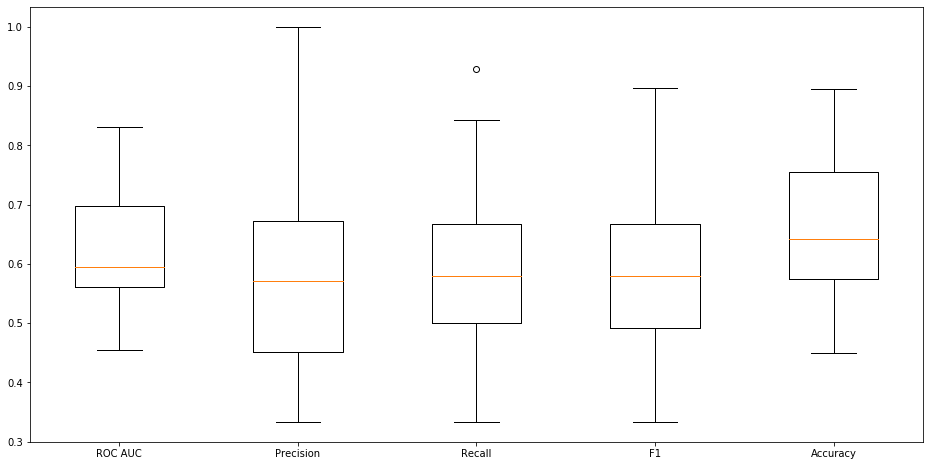

array([[0.74175824, 0.625     , 0.71428571, 0.66666667, 0.75      ],
       [0.58974359, 0.33333333, 0.33333333, 0.33333333, 0.75      ],
       [0.58888889, 0.33333333, 0.4       , 0.36363636, 0.69565217],
       [0.55555556, 0.63636364, 0.77777778, 0.7       , 0.6       ],
       [0.75      , 1.        , 0.5       , 0.66666667, 0.89473684],
       [0.6969697 , 0.57142857, 0.66666667, 0.61538462, 0.70588235],
       [0.60294118, 0.44444444, 0.5       , 0.47058824, 0.64      ],
       [0.5826087 , 0.47368421, 0.6       , 0.52941176, 0.57894737],
       [0.73931624, 0.83333333, 0.55555556, 0.66666667, 0.77272727],
       [0.49411765, 0.45454545, 0.58823529, 0.51282051, 0.48648649],
       [0.64210526, 0.66666667, 0.6       , 0.63157895, 0.64102564],
       [0.52678571, 0.55555556, 0.625     , 0.58823529, 0.53333333],
       [0.56349206, 0.5       , 0.57142857, 0.53333333, 0.5625    ],
       [0.52222222, 0.54545455, 0.6       , 0.57142857, 0.52631579],
       [0.58035714, 0.6875    , 0.

In [116]:
from pprint import pprint
plt.figure(figsize=(16,8))
plt.boxplot(scores)
plt.xticks(range(1,6,1),['ROC AUC',
                        'Precision',
                        'Recall',
                        'F1',
                         'Accuracy'])
plt.show()
pprint(scores)

In [117]:
confusion_matrix(Y,P)

array([[233, 113],
       [ 97, 161]])

[]

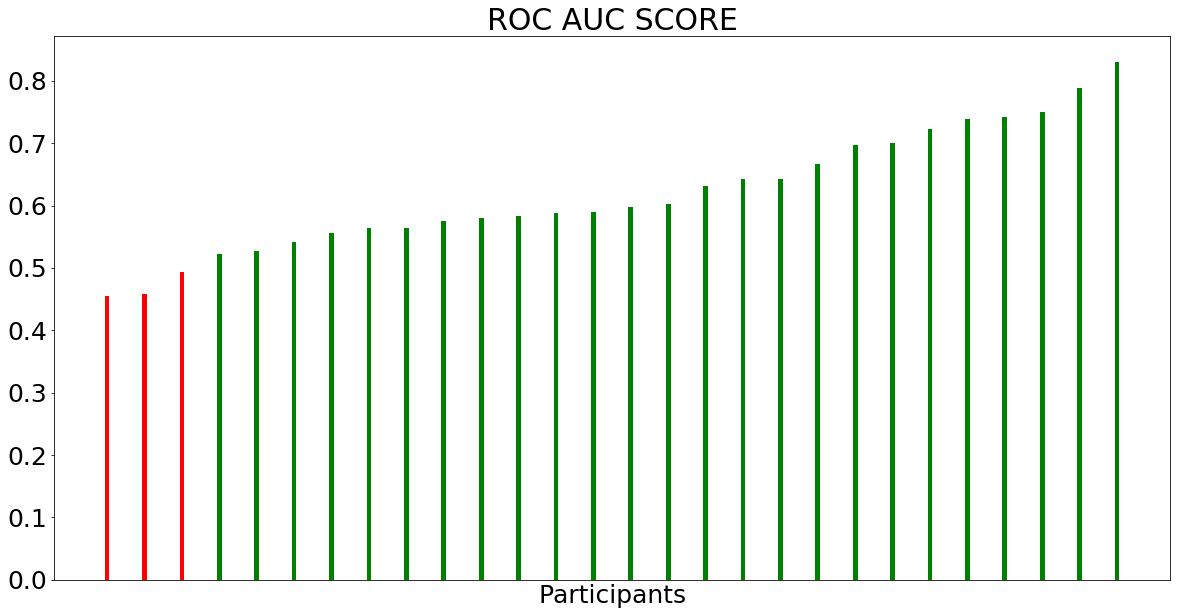

In [121]:
%matplotlib inline
plt.rcParams.update({'font.size':25})
scores = scores[scores[:,0].argsort()]
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,1,figsize=(20,10),sharex=True)
ax.bar(np.arange(0,4*scores.shape[0],4)[scores[:,0]<=.5],scores[scores[:,0]<=.5,0],.5,color='r')
ax.bar(np.arange(0,4*scores.shape[0],4)[scores[:,0]>.5],scores[scores[:,0]>.5,0],.5,color='g')
ax.set_title('ROC AUC SCORE')
# ax[0,1].bar(np.arange(scores.shape[0]),scores[:,1],.5)
# ax[1,0].bar(np.arange(scores.shape[0]),scores[:,2],.5)
# ax[1,1].bar(np.arange(scores.shape[0]),scores[:,3],.5,color='r')
ax.set_xlabel('Participants')
ax.set_xticks([])
# ax.set_xlabel('Participant Id')

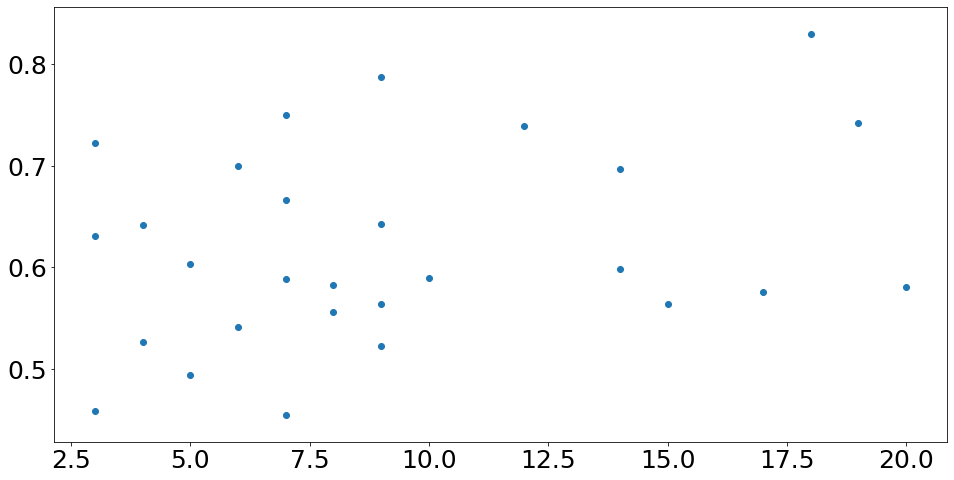

In [119]:
yields = np.array(yields)
plt.figure(figsize=(16,8))
plt.scatter(yields[:,0],scores[:,0])
plt.show()
# plt.colorbar()
# yields

In [124]:
np.mean(scores,axis=0)

array([0.61963345, 0.60256136, 0.58604674, 0.58125741, 0.667996  ])

In [ ]:

for y,y_pred,qual in a:
    if len(y)==0:
        continue
    temp = []
    qual_mean = np.array([np.mean(a) for a in qual])
    qual_std = np.array([np.std(a) for a in qual])
    for j in range(len(y)):
        temp.append([10*y[j]+y_pred[j],qual_mean[j],qual_std[j]])
    df = pd.DataFrame(temp,columns=['indicator','mean_s','std_s'])
    fig, ax = plt.subplots(figsize=(16,8))
    print(confusion_matrix(y,y_pred))
    plt.suptitle('')
    c = df.boxplot(column=['mean_s'], by='indicator', ax=ax,showfliers=False)
    print(df.groupby('indicator').count())
    plt.xticks(rotation=100)
    plt.title(roc_auc_score(y,y_pred))
    plt.show()